In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize

In [38]:
import sys
sys.path.append('../')  # go to parent dir
sys.path.append('/home/artem/git/sdafe')

### 6.5.1 BMW Returns

In [39]:
data = pd.read_csv('../data/bmwRet.csv', index_col=0, parse_dates=[0])
data.head()

,BMW.RET
X.Y..m..d,
1973-01-02,0.047704
1973-01-03,0.007127
1973-01-04,0.008883
1973-01-05,-0.012441
1973-01-08,-0.003570


In [40]:
ret = data['BMW.RET']

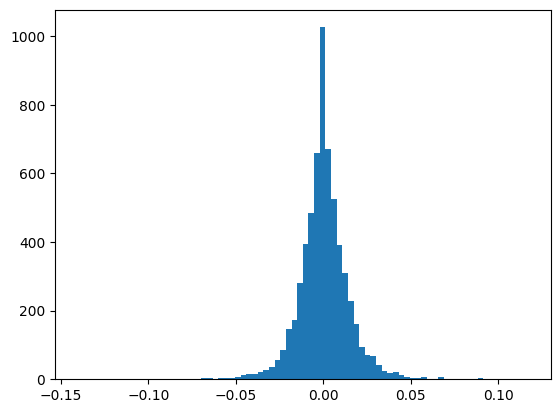

In [41]:
fig, ax = plt.subplots()
ax.hist(ret, bins=80);

In [42]:
stats.kurtosis(ret)

7.160895676188897

In [43]:
stats.skew(ret)

-0.04582926883223743

In [44]:
from common.distr import dsstd, qsstd, rsstd

In [45]:
loglik_f = lambda beta: np.sum(-np.log(dsstd(ret, mean=beta[0], sd=beta[1], nu=beta[2], xi=beta[3])))
start = np.array([np.mean(ret), np.std(ret, ddof=1), 2.5, 1])
fit_t = minimize(loglik_f, start, method='L-BFGS-B', bounds=[(-1, None), (0.001, None), (1, None), (0, None)])
fit_t

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -17865.60827709669
        x: [ 3.857e-04  1.611e-02  2.989e+00  1.033e+00]
      nit: 39
      jac: [ 2.197e-01 -1.267e+00 -8.004e-03 -4.729e-02]
     nfev: 245
     njev: 49
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [46]:
def plot_qq(xs, qf):
    qs = np.array([0.25, 0.75])
    n = len(xs)

    fig, ax = plt.subplots()
    ax.scatter(qf((np.arange(1, n + 1) - 0.5) / n), np.sort(xs))
    ax.set_xlabel('theoretical quantiles')
    ax.set_ylabel('empirical quantiles')
    
    # draw a regression line through 0.25 and 0.75 quantiles
    coord = lambda q: (qf(q), np.quantile(xs, q))
    ax.axline(coord(qs[0]), coord(qs[1]), color='red')

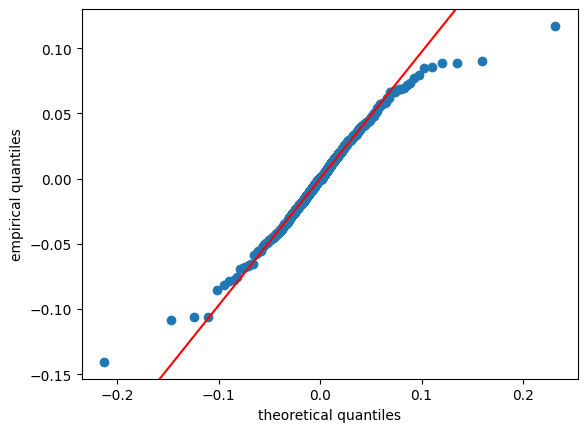

In [47]:
plot_qq(ret, lambda ps: qsstd(ps, *fit_t.x))

#### Problem 1

The MLE of $\nu$ is 2.989. A t-distribution with this value of $\nu$ does not have a skewness or kurtosis.

#### Problem 2

In [48]:
def qu_kurt(qf, p1=0.025, p2=0.25):
    return (qf(1 - p1) - qf(p1)) / (qf(1 - p2) - qf(p2))

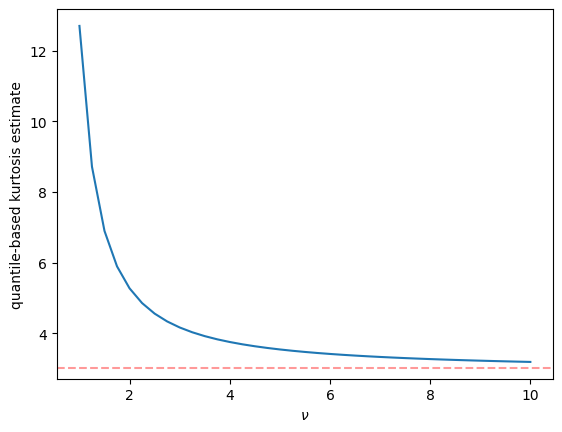

In [49]:
nus = np.linspace(1, 10, 9 * 4 + 1)

fig, ax = plt.subplots()
ax.plot(nus, qu_kurt(lambda p: stats.t.ppf(p, nus)))
ax.set_xlabel('$\\nu$')
ax.set_ylabel('quantile-based kurtosis estimate');
ax.axhline(3, linestyle='--', color='red', alpha=0.4);

In [50]:
rng = np.random.default_rng()

In [51]:
def bootstrap(sample, resample_fun, n_resamples, estimator_fun):
    return np.fromiter(
        (estimator_fun(resample_fun(sample)) for _ in range(n_resamples)),
        float
    )

In [52]:
n_boot = 5000
estimator_fun = lambda xs: qu_kurt(lambda p: np.quantile(xs, p))
model_free_kurt = bootstrap(ret, lambda xs: rng.choice(xs, len(xs)), n_boot, estimator_fun)
model_based_kurt = bootstrap(ret, lambda xs: rsstd(len(ret), *fit_t.x), n_boot, estimator_fun)

#### Problem 2

In [53]:
def plot_with_kde(x, ax, title):
    ax.hist(x, bins=50, density=True, alpha=0.4, label=f'{title}')
    sns.kdeplot(x, ax=ax, label=title)

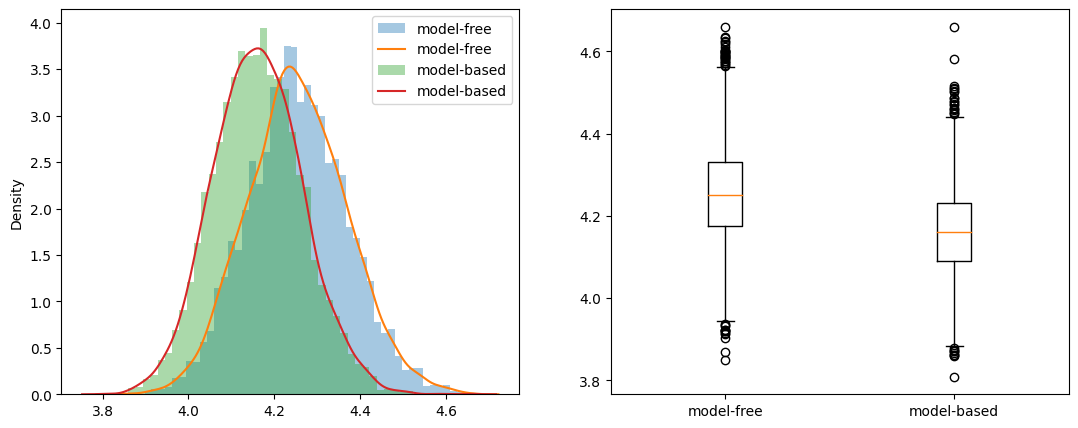

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

plot_with_kde(model_free_kurt, axs[0], 'model-free')
plot_with_kde(model_based_kurt, axs[0], 'model-based')
axs[0].legend();

axs[1].boxplot([model_free_kurt, model_based_kurt], labels=['model-free', 'model-based']);

The kurtosis estimate from the model-based bootstrap is lower and has smaller standard deviation than the estimate from model-free bootstrap.

#### Problem 3

In [55]:
conf = 0.9

Percentile-method confidence intervals for the model-free estimate:

In [56]:
np.quantile(model_free_kurt, [(1 - conf) / 2, 1 - (1 - conf) / 2])

array([4.06708641, 4.44624738])

Percentile-method confidence intervals for the model-based estimate:

In [57]:
np.quantile(model_based_kurt, [(1 - conf) / 2, 1 - (1 - conf) / 2])

array([3.99578842, 4.33800642])

#### Problem 4

BCa confidence interval:

In [58]:
bca_conf_int = stats.bootstrap((ret,), estimator_fun, n_resamples=5000, method='bca', confidence_level=conf)
bca_conf_int.confidence_interval

ConfidenceInterval(low=4.108199640453652, high=4.486804436025646)

The iterval is close to the percentile-based interval for the model-free estimate above.

### 6.5.2 Simulation Study: Bootstrapiping the Kurtosis

In [59]:
def kurt(x):
    return np.mean(((x - np.mean(x)) / np.std(x, ddof=1)) ** 4)

In [60]:
n_iter = 500
n_boot = 400
n = 50
nu = 10
true_kurtosis = 3 + 6 / (nu - 4)

In [61]:
conf = 0.95

In [62]:
def boott(x, theta, nboott, nbootsd, perc, sdfun=None, rng=None):
    """Implementation of bootstrap-t method from https://github.com/cran/bootstrap/blob/master/R/boott.R"""
    if rng is None:
        rng = np.random.default_rng()
    
    if sdfun is None:
        def sdfun(x, nboot, theta):
            n = len(x)
            samples = rng.choice(x, (nboot, n))
            return np.std(np.apply_along_axis(theta, 1, samples), ddof=1)

    theta_hat = theta(x)
    sd = sdfun(x, nbootsd, theta)

    n = len(x)
    
    x_star = rng.choice(x, (nboott, n))
    theta_star = np.apply_along_axis(theta, 1, x_star)
    sd_star = np.apply_along_axis(sdfun, 1, x_star, nbootsd, theta)
    t_star = (theta_hat - theta_star) / sd_star

    return theta_hat + sd * np.quantile(t_star, perc)

In [63]:
def evaluate_conf_ints(statistic, true_value, n_iter, n_boot, n, nu, conf, rng):
    correct = np.zeros((n_iter, 5))
    width = np.zeros((n_iter, 5))
    error = np.zeros(n_iter)
    mse = np.zeros(n_iter)

    for i in range(n_iter):
        def update_stats(j, low, high):
            width[i, j] = high - low
            correct[i, j] = (low <= true_value <= high)        

        y = stats.t.rvs(size=n, df=nu)

        # bootstrap-t method
        int1 = boott(y, statistic, n_boot, 50, [(1 - conf) / 2, 1 - (1 - conf) / 2], rng=rng)
        update_stats(0, int1[0], int1[1])

        # BCa method
        boot = stats.bootstrap((y,), statistic, n_resamples=n_boot, method='bca', confidence_level=conf)
        update_stats(1, boot.confidence_interval[0], boot.confidence_interval[1])

        qs = np.quantile(boot.bootstrap_distribution, [(1 - conf) / 2, 1 - (1 - conf) / 2])
        theta = statistic(y)

        # normal assumption method
        sd = np.std(boot.bootstrap_distribution, ddof=1)
        alpha_norm = stats.norm.ppf(1 - (1 - conf) / 2)
        update_stats(2, theta - alpha_norm * sd, theta + alpha_norm * sd)

        # percentile method
        update_stats(3, qs[0], qs[1])

        # basic method
        update_stats(4, 2 * theta - qs[1], 2 * theta - qs[0])

        error[i] = np.mean(boot.bootstrap_distribution) - theta    
        mse[i] = np.mean((boot.bootstrap_distribution - theta) ** 2)
    
    return (correct, width, error, mse)

In [64]:
%time correct, width, error, mse = evaluate_conf_ints(kurt, true_kurtosis, n_iter, n_boot, n, nu, conf, rng)

CPU times: user 16min 8s, sys: 111 ms, total: 16min 9s
Wall time: 16min 10s


In [66]:
np.mean(correct, axis=0)

array([0.626, 0.626, 0.532, 0.552, 0.482])

In [67]:
np.mean(width, axis=0)

array([5.30987219, 2.92047867, 2.62814881, 2.50357058, 2.50357058])

In [68]:
np.mean(error)

-0.17176975991409177

#### Problem 6

The bootstrap intervals used are:

   * bootstrap-t,
   * BCa,
   * normal,
   * percentile,
   * basic.

#### Problem 7

The number of resamples is 400.

#### Problem 8

The number of simulations is 500.

#### Problem 9

The estimate of bias is:

In [69]:
np.mean(error)

-0.17176975991409177

#### Problem 10

The estimated MSE is:

In [70]:
np.mean(mse)

0.7592383605408738

#### Problem 11

The estimated coverage probability of BCa:

In [71]:
np.mean(correct[:, 1])

0.626

The estimated coverage probability of bootstrap-t:

In [72]:
np.mean(correct[:, 0])

0.626

#### Problem 12

In [73]:
n_iter = 500
n_iter_outer = 500

In [ ]:
def bca_correct():
    correct = 0
    for j in range(n_iter):
        y = stats.t.rvs(size=n, df=nu)
    
        # BCa method
        boot = stats.bootstrap((y,), kurt, n_resamples=n_boot, method='bca', confidence_level=conf)
        correct += (boot.confidence_interval[0] <= true_kurtosis <= boot.confidence_interval[1])

    return correct / n_iter

correct = np.fromiter((bca_correct() for _ in range(n_iter_outer)), float)

Using the basic method:

In [ ]:
theta = np.mean(correct)
conf = 0.95
qL = np.quantile(correct, (1 - conf) / 2)
qU = np.quantile(correct, 1 - (1 - conf) / 2)

The confidence interval is then:

In [ ]:
2 * theta - np.array([qU, qL])

#### Problem 13

The interval provided by BCa appears to be the most accurate. It is sufficiently accurate at 70%.

#### Problem 15

In [41]:
def qu_kurt(x, p1=0.025, p2=0.25):
    Q = np.quantile(x, [p1, p2, 1-p2, 1-p1])
    return (Q[3] - Q[0]) / (Q[2] - Q[1])

In [42]:
p1 = 0.025
p2 = 0.25
true_kurtosis = (stats.t.ppf(1-p1, df=nu) - stats.t.ppf(p1, df=nu)) / (stats.t.ppf(1-p2, df=nu) - stats.t.ppf(p2, df=nu))

In [43]:
%time correct, width, error, mse = evaluate_conf_ints(qu_kurt, true_kurtosis, n_iter, n_boot, n, nu, conf, rng)

CPU times: user 25min 22s, sys: 68 ms, total: 25min 22s
Wall time: 25min 23s


In [44]:
np.mean(correct, axis=0)

array([0.89 , 0.938, 0.938, 0.96 , 0.82 ])

In [45]:
np.mean(width, axis=0)

array([2.81363378, 2.88019076, 2.87979395, 2.7848216 , 2.7848216 ])

The most accurate interval is the one given by the normal approximation method. All five intervals appear to be quite accurate in this case.